In [ ]:
# parameters, export
seed = 0

jax_enable_x64 = True
r = 5
beta = 0.0
alpha_scale = 1.0
kappa = 1.0
prior_pi = 0.95
ell = 0.5

In [2]:
import jax

jax.config.update("jax_log_compiles", False)
jax.config.update("jax_enable_x64", jax_enable_x64)

master_key = jax.random.PRNGKey(seed)

In [3]:
import jax.numpy as jnp

from iklp.hyperparams import (
    ARPrior,
    pi_kappa_hyperparameters,
    solve_for_alpha,
)
from iklp.mercer import psd_svd_fixed
from utils.jax import maybe32
from utils.openglot import OpenGlotI
from utils.audio import frame_signal
from iklp.mercer_op import backend
from utils import time_this
from iklp.run import vi_run_criterion_batched

from tqdm import tqdm
import numpy as np


In [4]:
P = 8
f0 = np.arange(100, 360 + 1, 10)
I = len(f0)

target_fs = 8000
M = 1024  # frame length
hop = 80

max_vi_iter = 50
batch_size = 256 if jax_enable_x64 else 512

In [5]:
dt = 1.0 / target_fs
t = np.arange(M) * dt
tau = t[:, None] - t[None, :]
T = (1 / f0)[:, None, None]
K = np.exp(-2 * (np.sin(np.pi * tau / T)) ** 2 / (ell**2))  # (I, M, M)
Phi, energy = psd_svd_fixed(K, rank=r)

print(f"Energy captured at rank={r}:", energy)

Energy captured at rank=25: [0.99999993 0.99999993 0.99999993 0.99999993 0.99999993 0.99999993
 0.99999993 0.99999993 0.99999993 0.99999993 0.99999993 0.99999993
 0.99999993 0.99999993 0.99999993 0.99999993 0.99999993 0.99999993
 0.99999993 0.99999993 0.99999993 0.99999993 1.         0.99999993
 0.99999993 0.99999993 0.99999993]


In [6]:
arprior = ARPrior.yoshii_lambda(P)


In [7]:
alpha = solve_for_alpha(I) * alpha_scale

h = pi_kappa_hyperparameters(
    maybe32(Phi),
    pi=maybe32(prior_pi),
    kappa=maybe32(kappa),
    alpha=maybe32(alpha),
    arprior=arprior,
    num_metrics_samples=1,
    num_vi_iters=max_vi_iter,
    beta=maybe32(beta),
)

del K, Phi

print("Phi shape:", h.Phi.shape)  # (I, M, r)
print("Phi dtype:", h.Phi.dtype)
print("Mercer operator backend:", backend(h))

Phi shape: (27, 1024, 25)
Phi dtype: float64
Mercer operator backend: <module 'iklp.mercer_op.woodbury' from '/home/marnix/thesis/src/iklp/mercer_op/woodbury.py'>


In [8]:
def all_runs(verbose=False):
    for wav_file in tqdm(OpenGlotI.wav_files()):
        vowel, modality, true_pitch = OpenGlotI.parse_wav(wav_file)
        true_formants = OpenGlotI.true_resonance_frequencies[vowel]
        x_full, dgf_full, original_fs = OpenGlotI.read_wav(
            wav_file, target_fs, verbose=verbose
        )

        x_frames = frame_signal(x_full, M, hop)  # ((n_frames, frame_len)
        dgf_frames = frame_signal(dgf_full, M, hop)

        x_frames = maybe32(x_frames)
        dgf_frames = maybe32(dgf_frames)

        for frame_index, (x, dgf) in enumerate(zip(x_frames, dgf_frames)):
            for restart_index in range(h.num_vi_restarts):
                yield {
                    "wav_file": wav_file,
                    "original_fs": original_fs,
                    "target_fs": target_fs,
                    "vowel": vowel,
                    "modality": modality,
                    "true_pitch": true_pitch,
                    "true_formants": true_formants,
                    "frame_index": frame_index,
                    "num_frames": x_frames.shape[0],
                    "restart_index": restart_index,
                    "x": x,
                    "dgf": dgf,
                    "x_frames": x_frames,
                    "dgf_frames": dgf_frames,
                }


runs = list(all_runs())

print("Total runs:", len(runs))


100%|██████████| 336/336 [00:00<00:00, 920.68it/s]

Total runs: 2688


In [9]:
x = jnp.vstack([run["x"] for run in runs])

print("Data shape:", x.shape)
print("Data dtype:", x.dtype)

Data shape: (2688, 1024)
Data dtype: float64


In [11]:
with time_this() as elapsed:
    metrics_tree, unpack = vi_run_criterion_batched(
        master_key, x, h, batch_size=batch_size, verbose=True
    )

metrics_list = list(unpack(metrics_tree))

100%|██████████| 11/11 [24:22<00:00, 132.93s/it]


Walltime: 1463.008 s


In [12]:
# export
# Mean energy captured by the chosen rank `r`
mean_energy = np.mean(energy)

# This includes compilation for the shapes of the first and last batch, which are O(1) min
time_per_iter = elapsed.walltime / metrics_tree.i.sum()

results = [
    OpenGlotI.post_process_run(run, metrics, f0)
    for run, metrics in tqdm(zip(runs, metrics_list))
]

2688it [00:27, 96.12it/s] 


1680


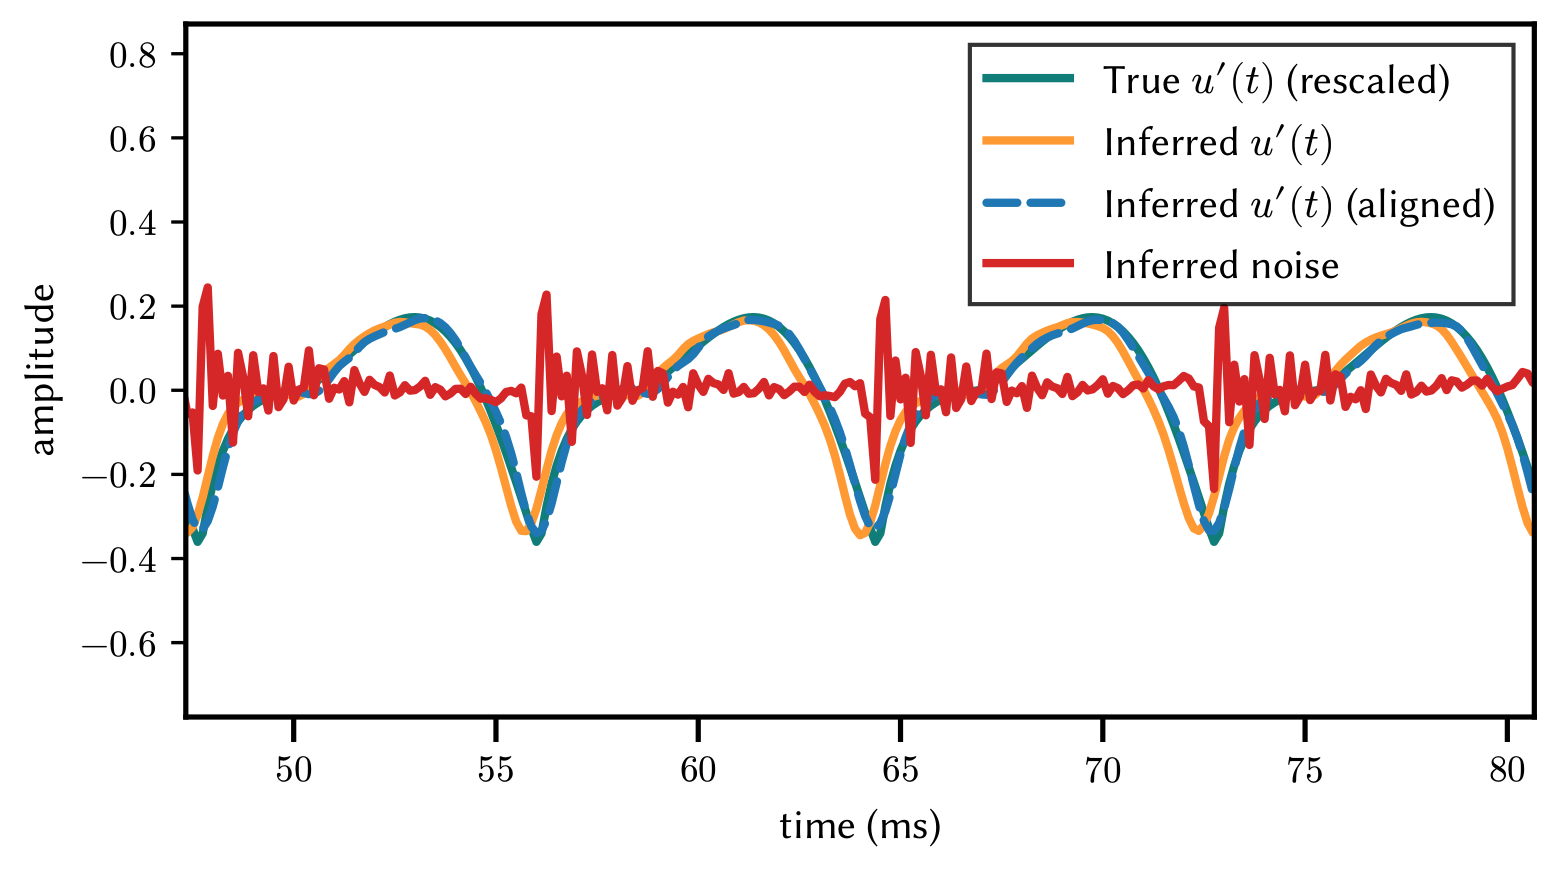

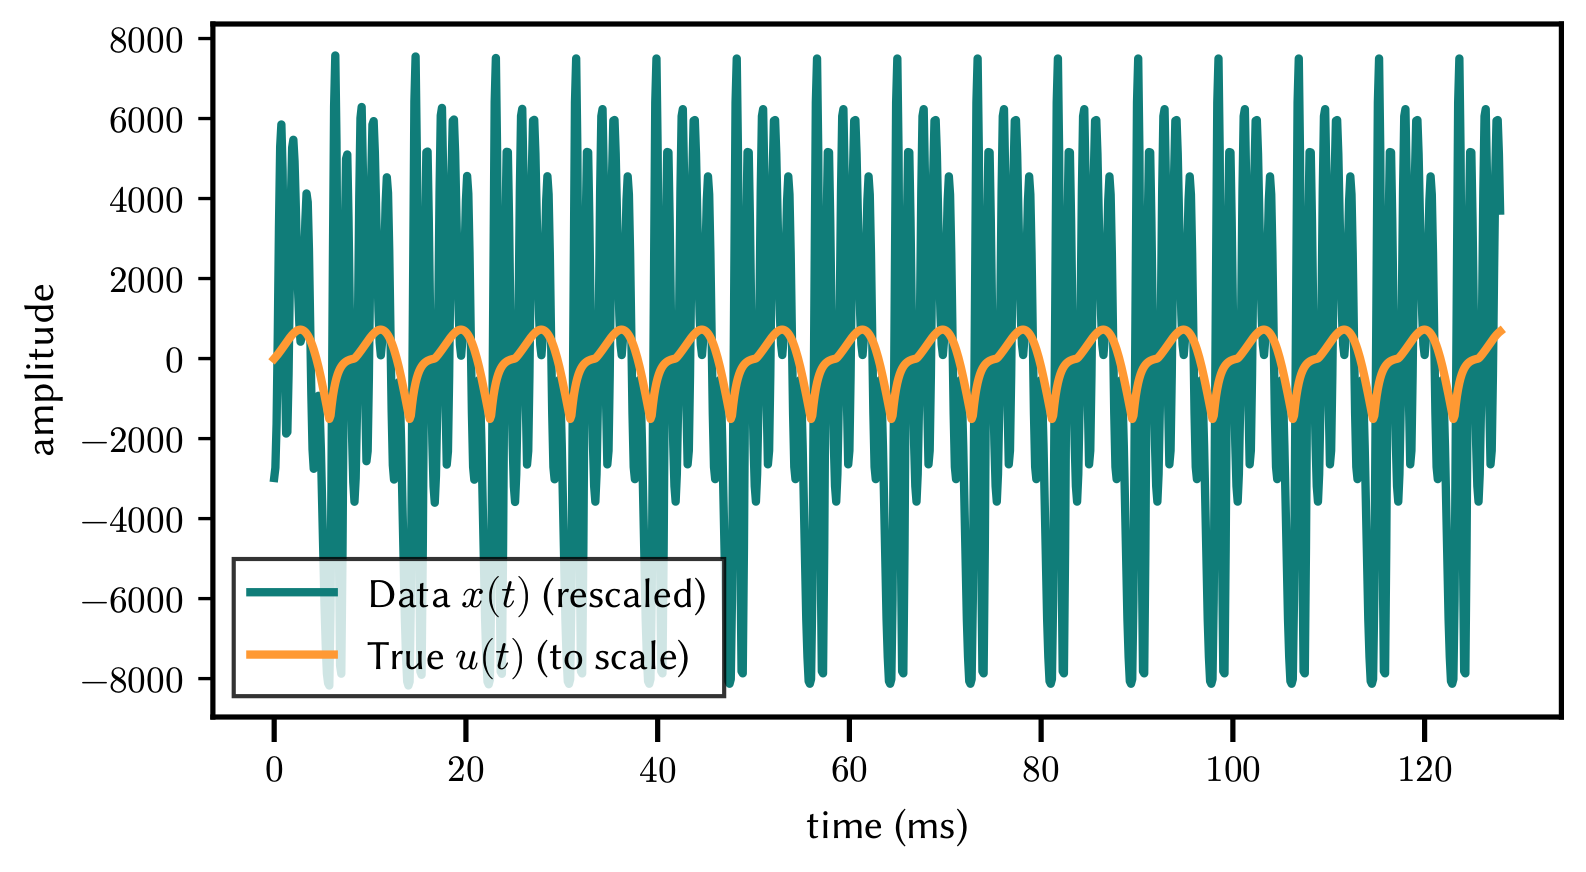

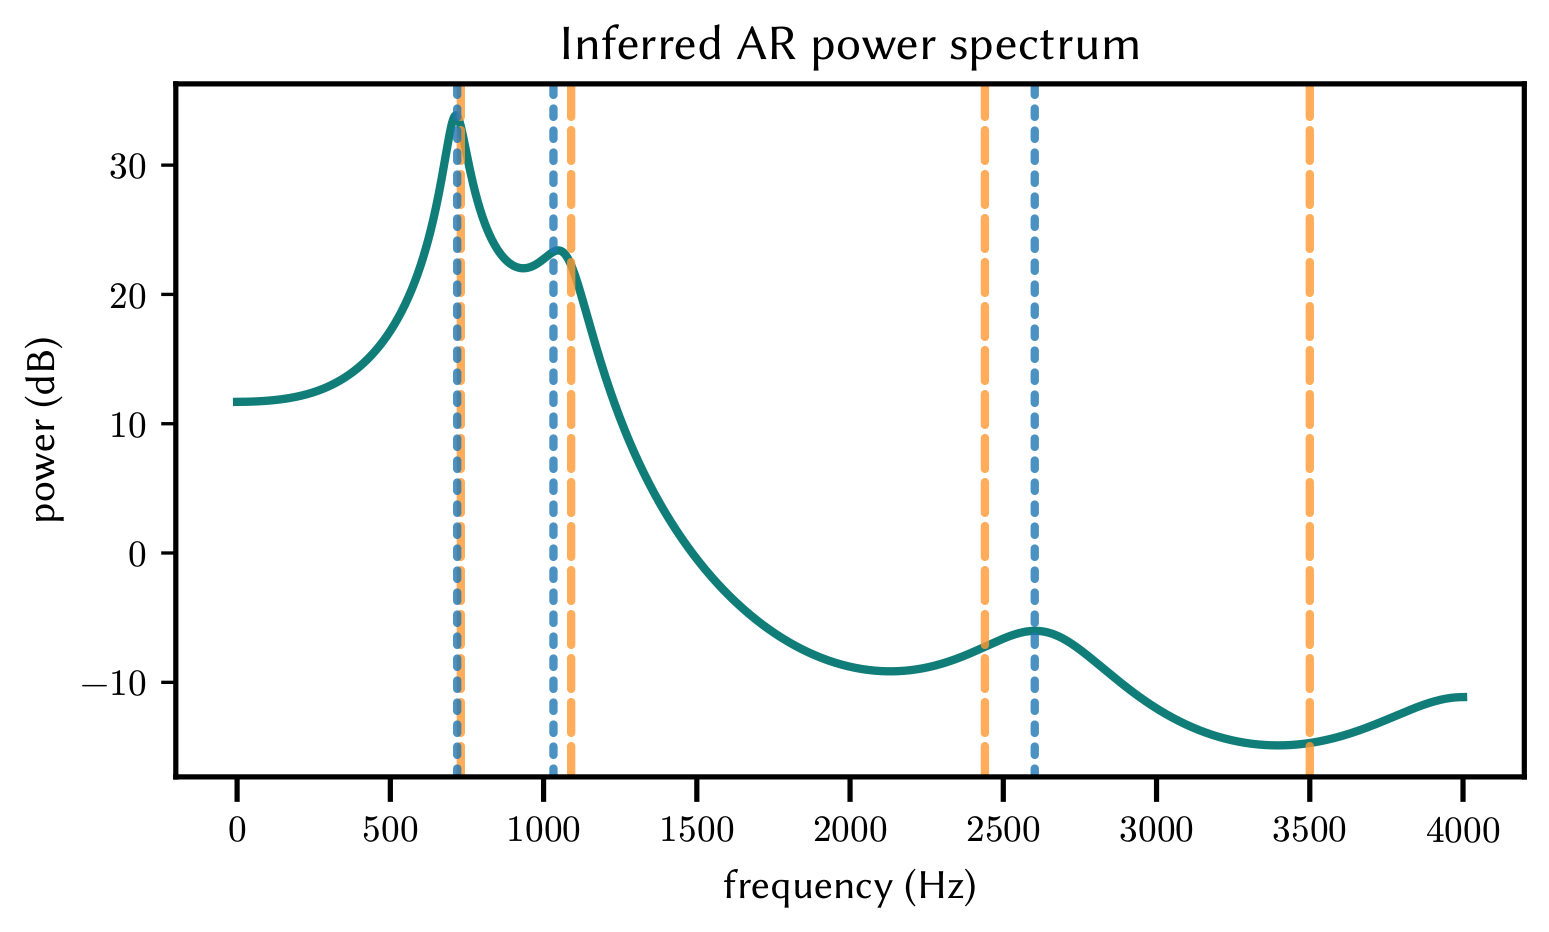

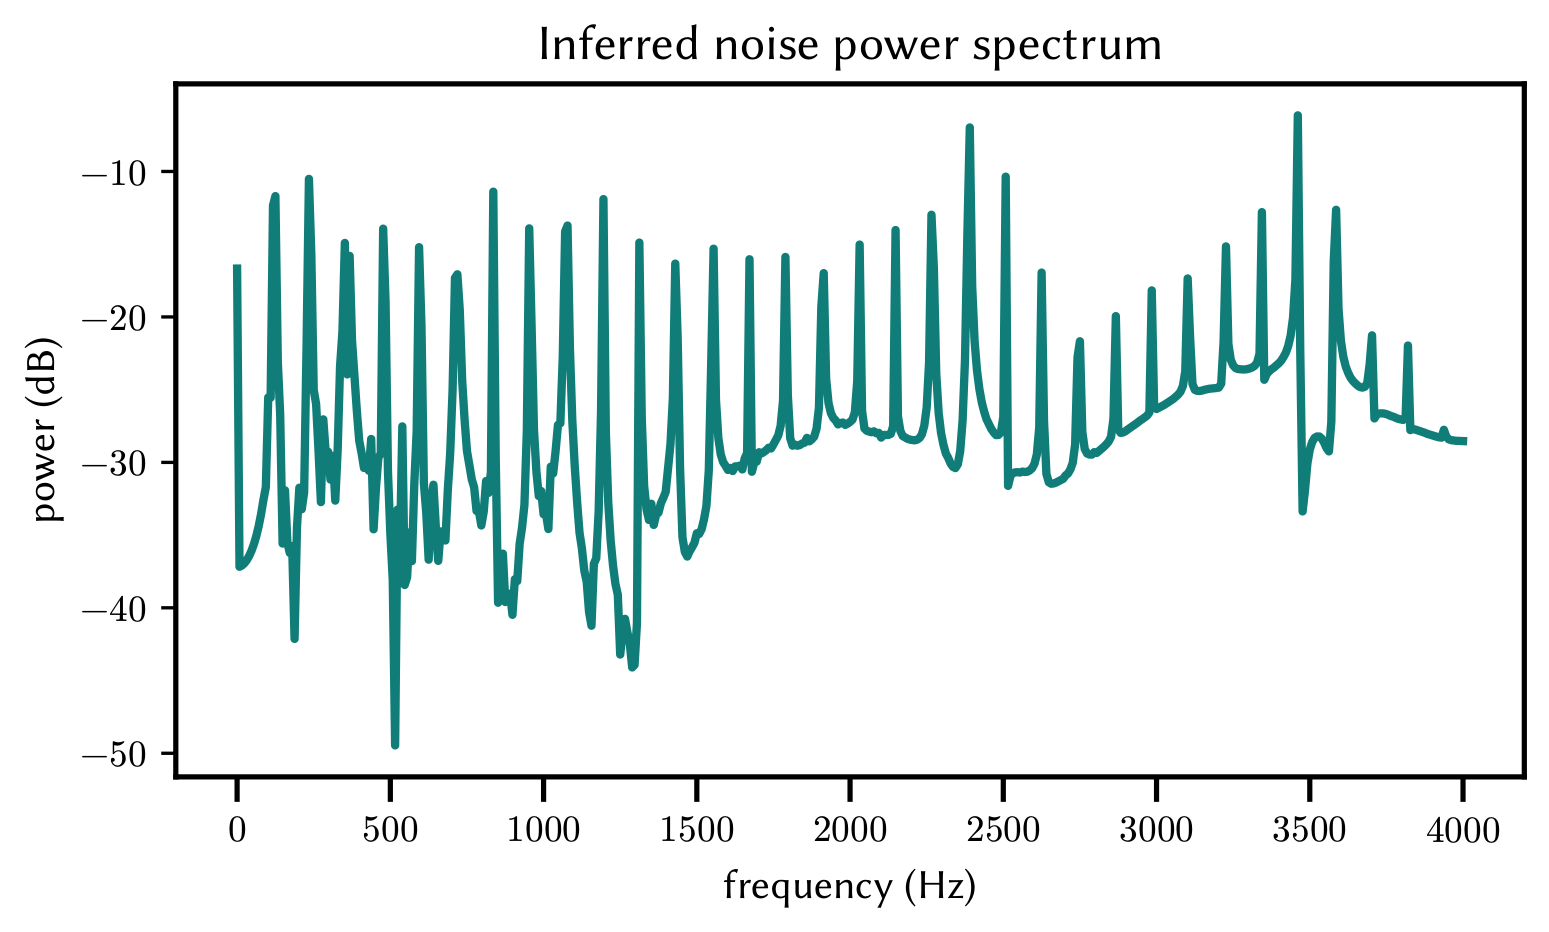

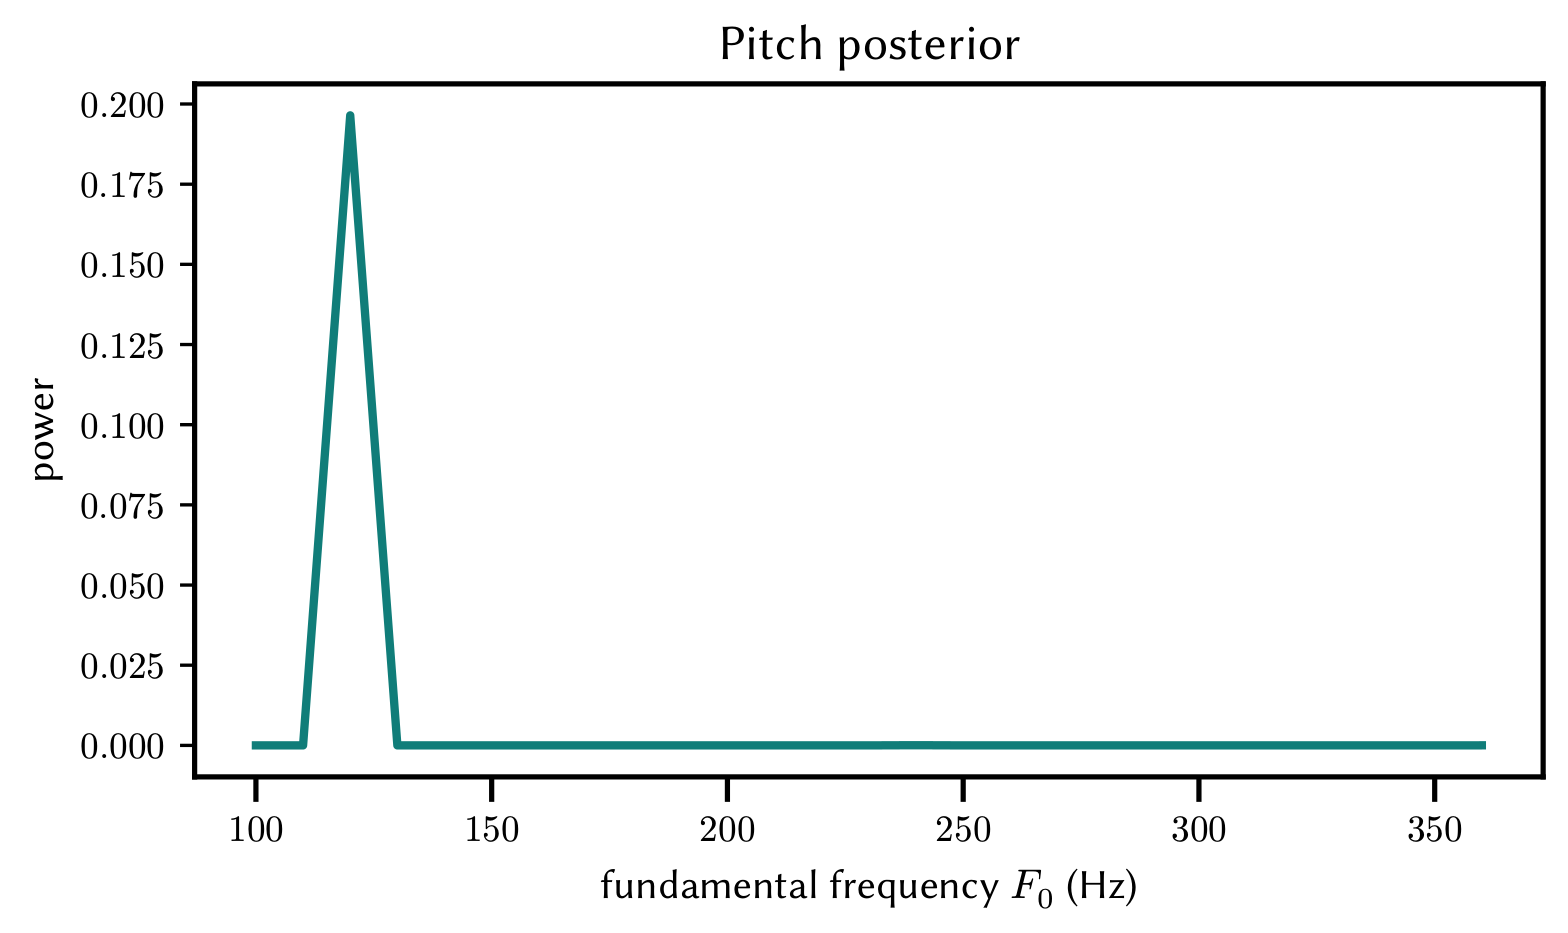

[<Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>]

In [13]:
from utils.openglot import OpenGlotI

# Plot best u'(t) fit
i = int(np.nanargmin([r["dgf_aligned_nrmse"] for r in results]))
print(i)

OpenGlotI.plot_run(runs[i], metrics_list[i], f0, retain_plots=True)

686


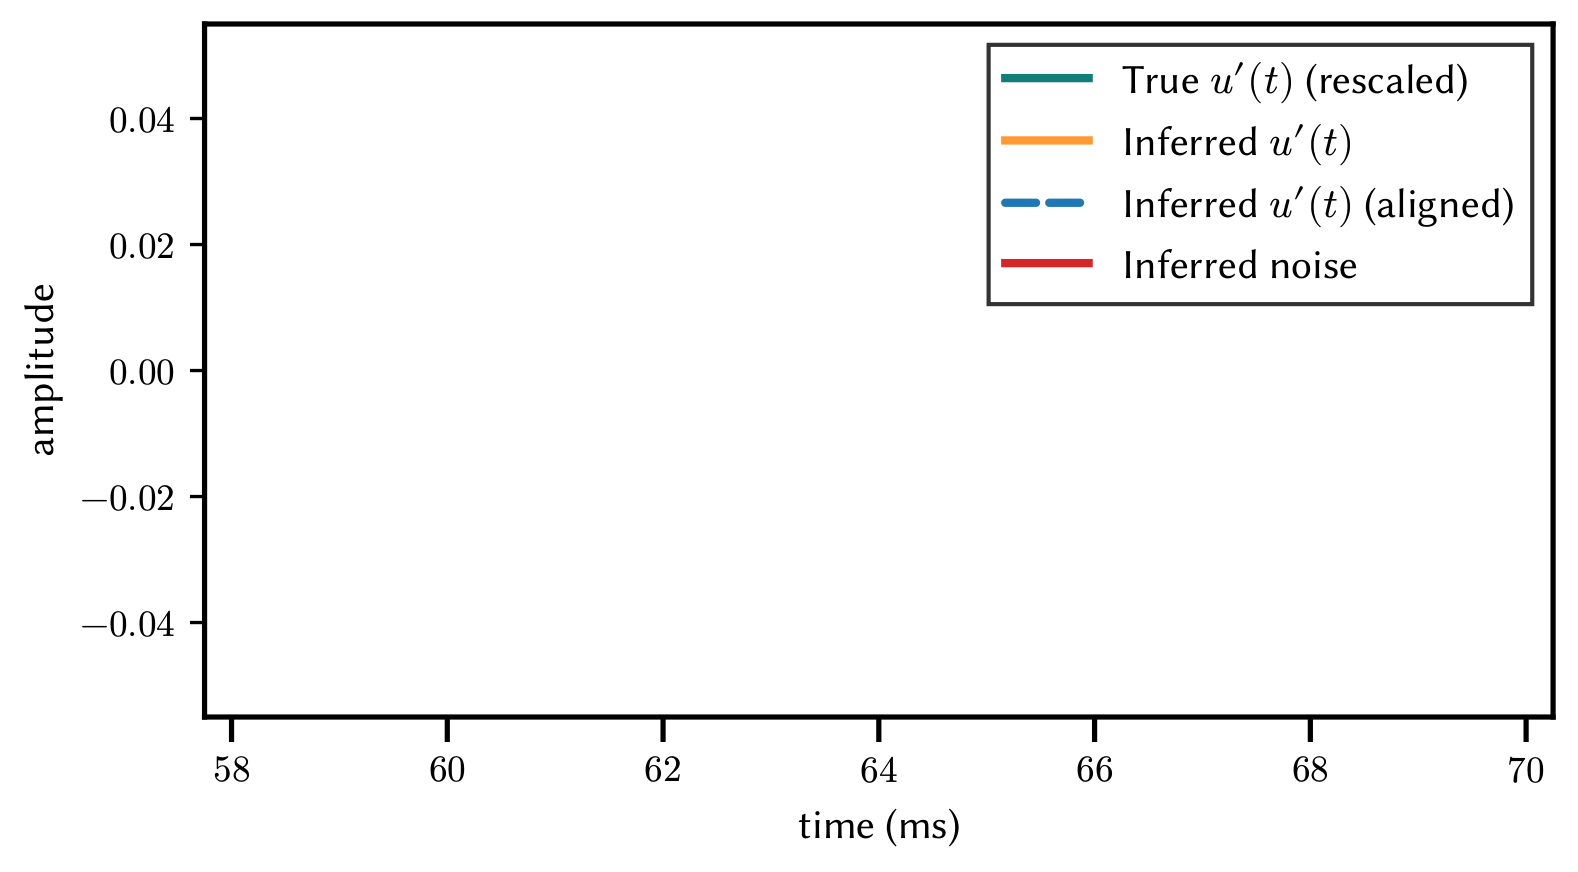

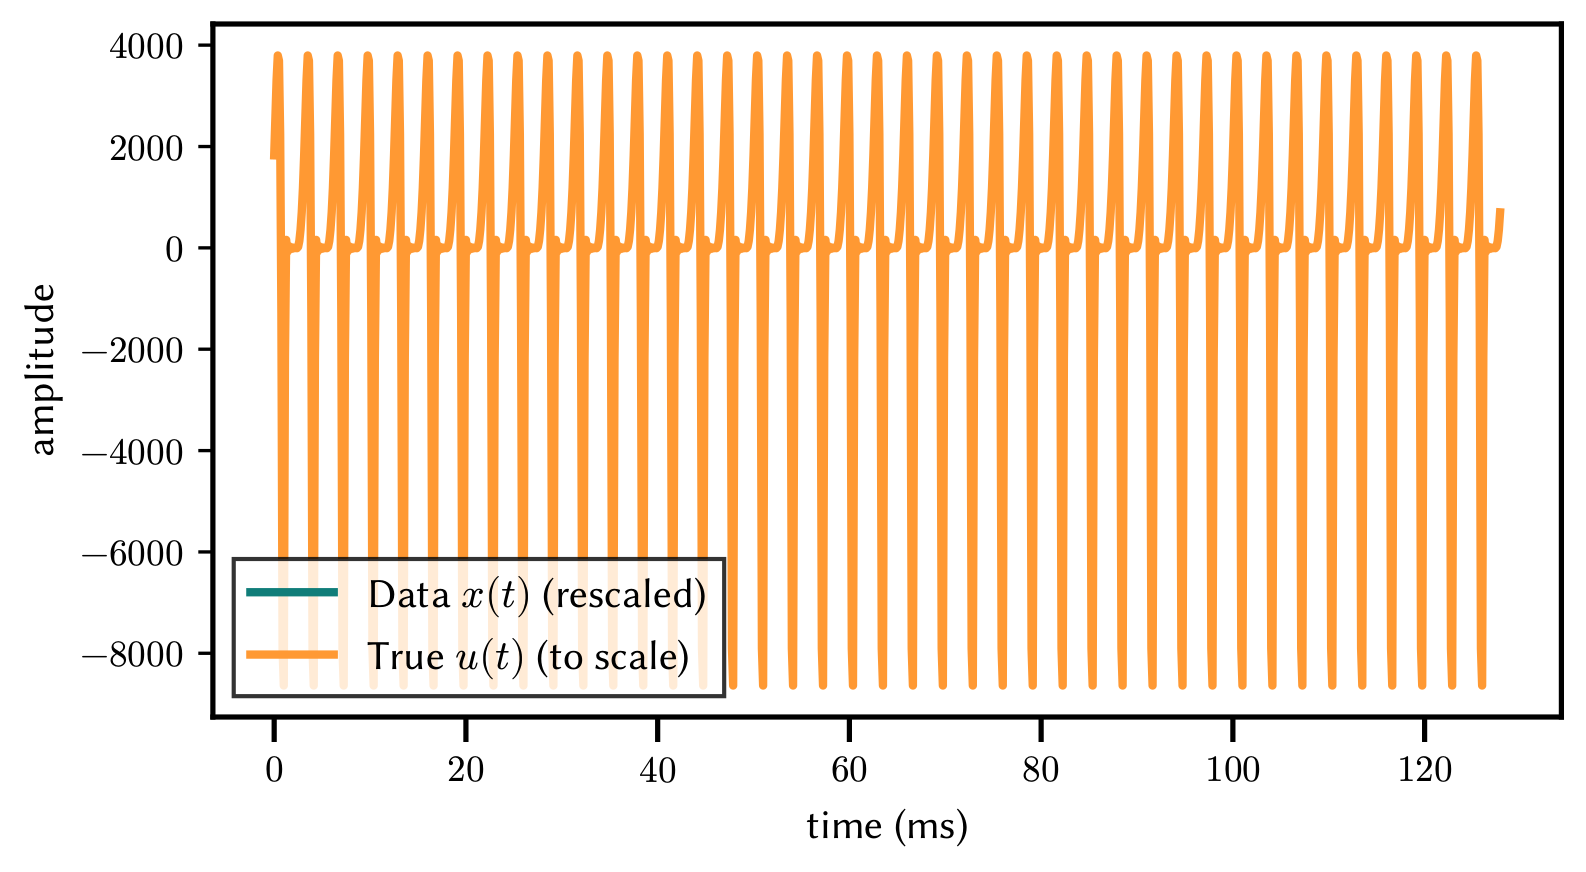

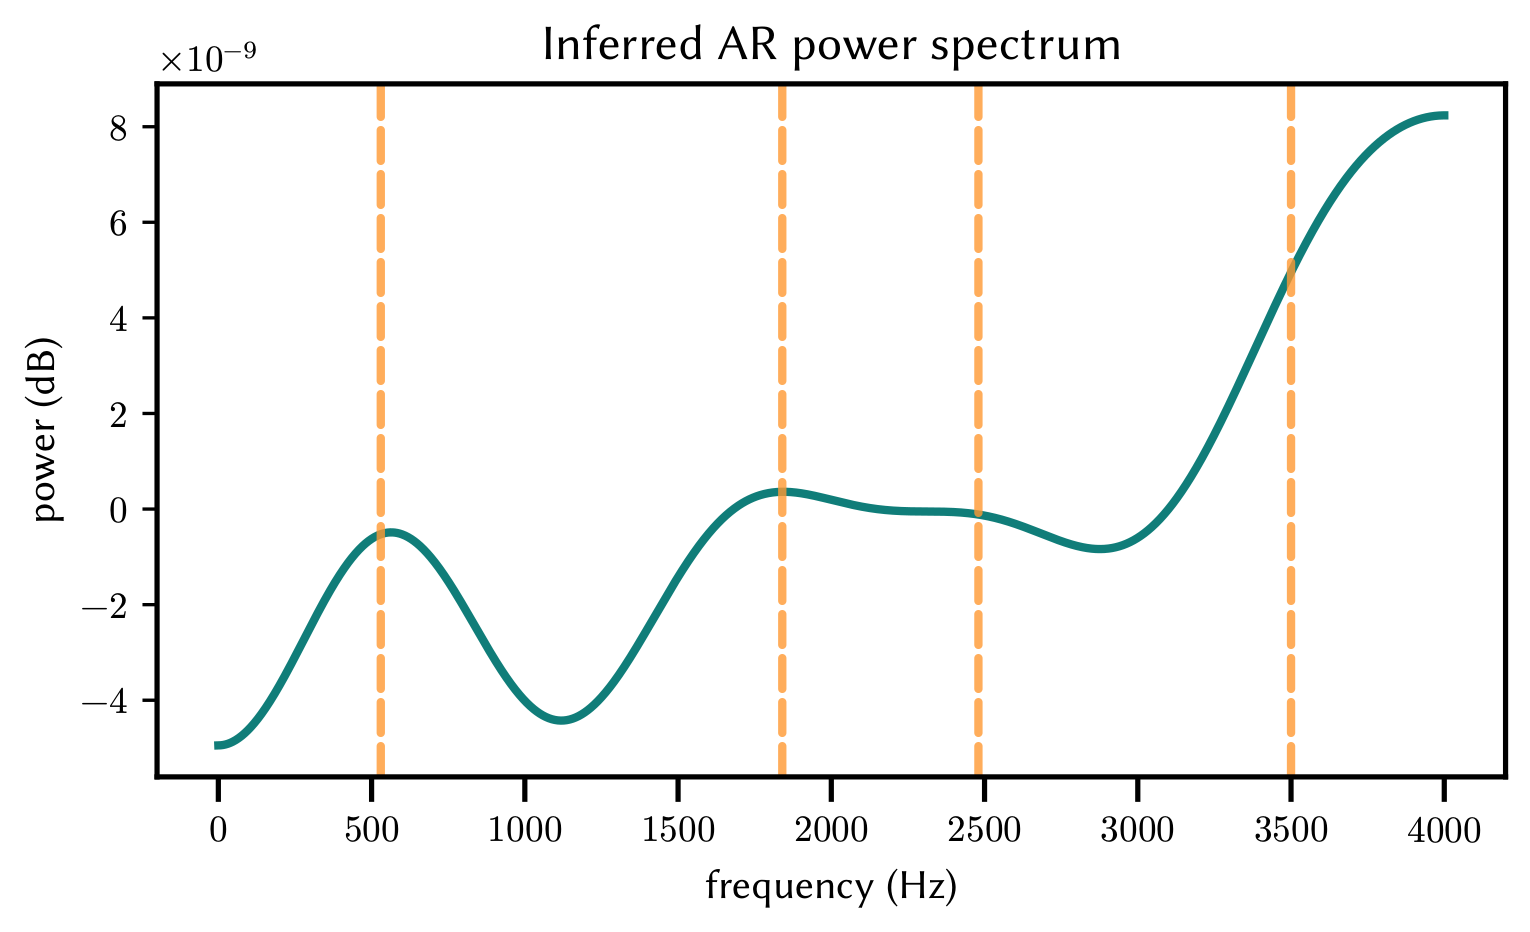

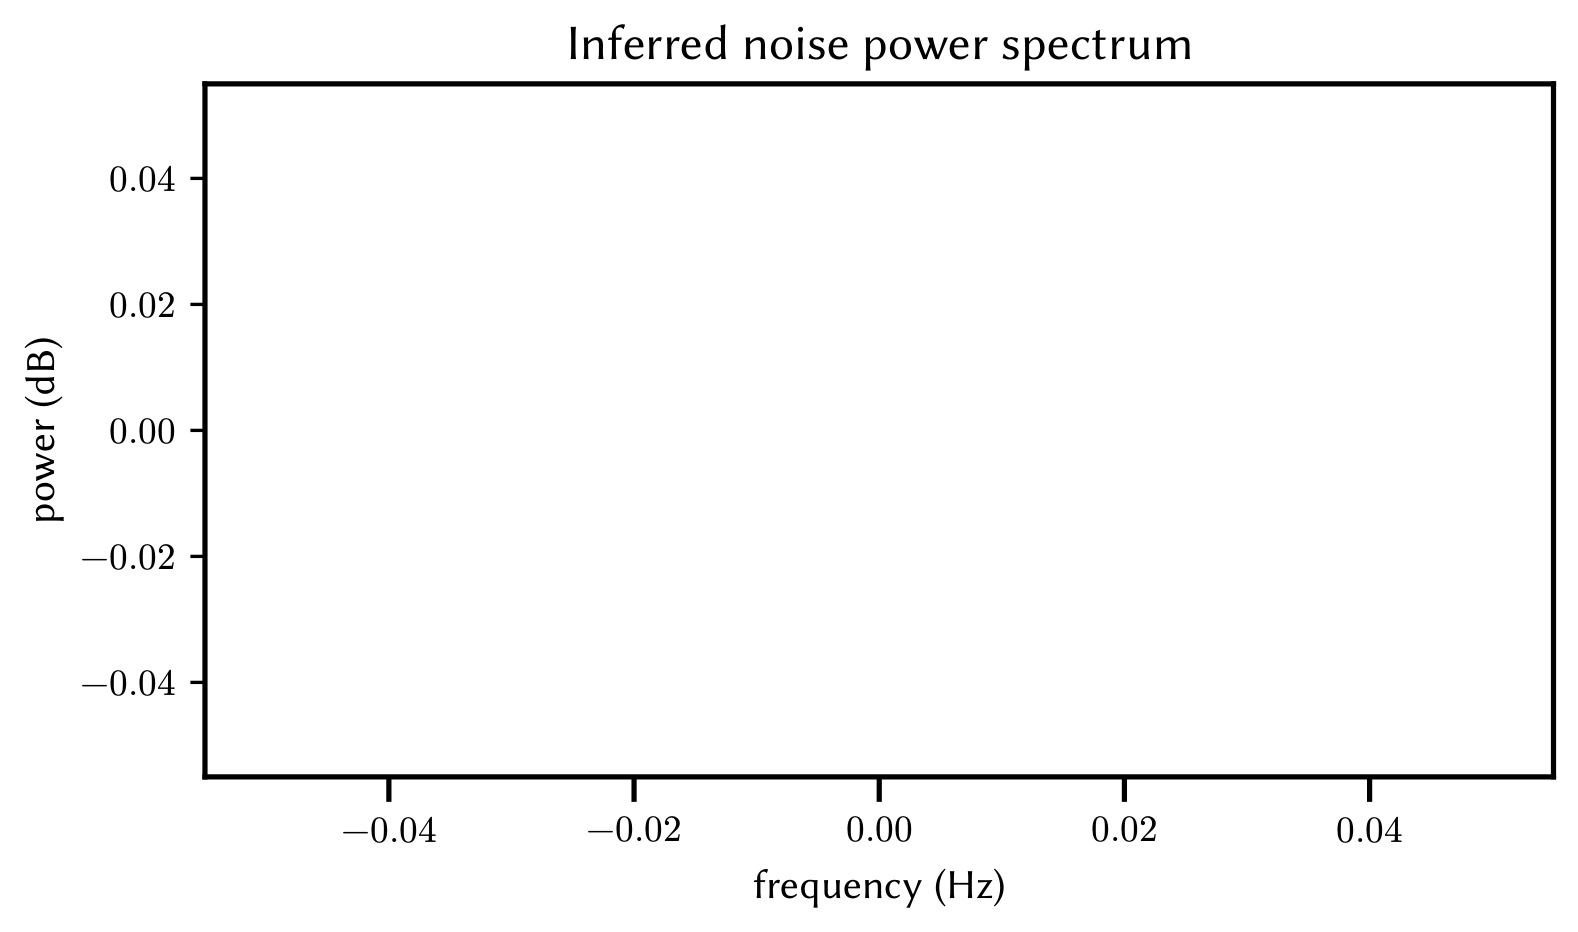

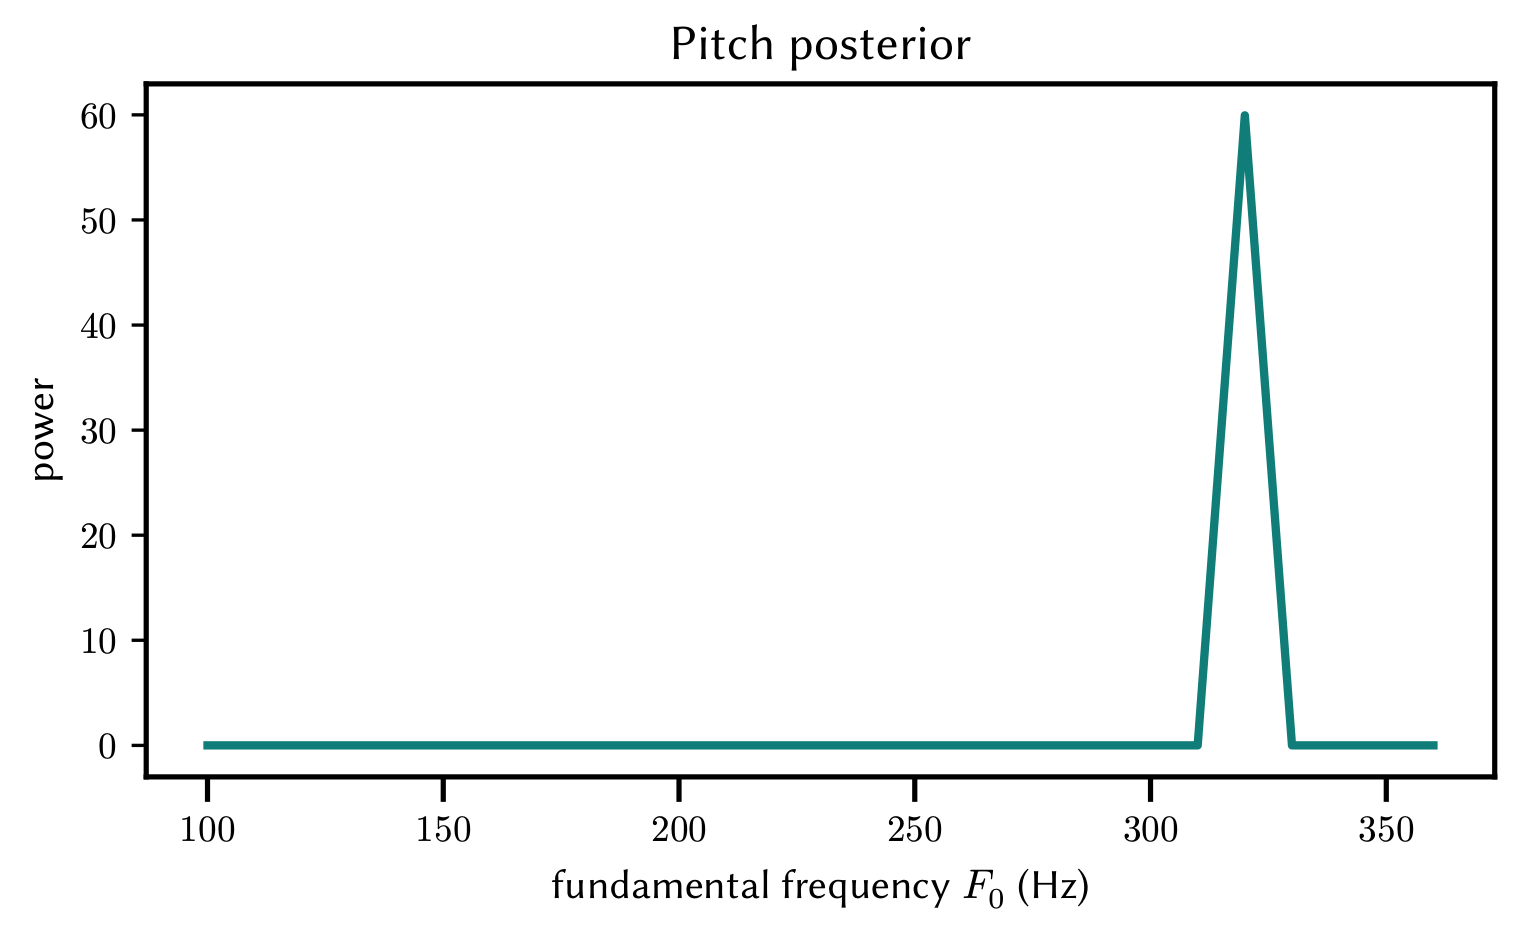

[<Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>]

In [14]:
# Plot best pitch fit
i = int(np.nanargmin([r["pitch_wrmse"] for r in results]))
print(i)

OpenGlotI.plot_run(runs[i], metrics_list[i], f0, retain_plots=True)

2210


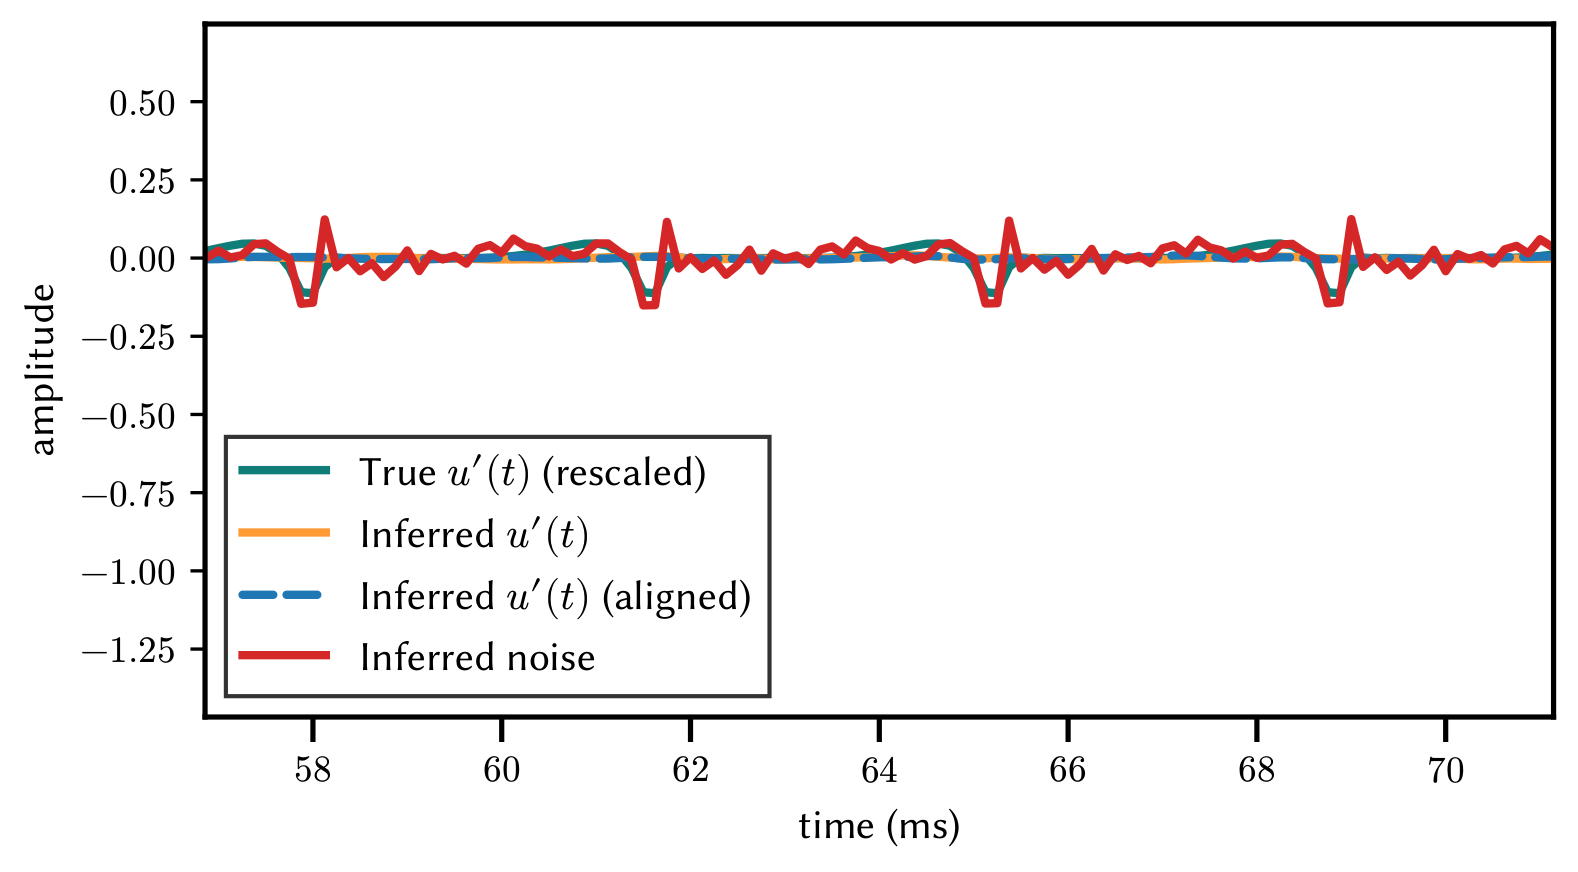

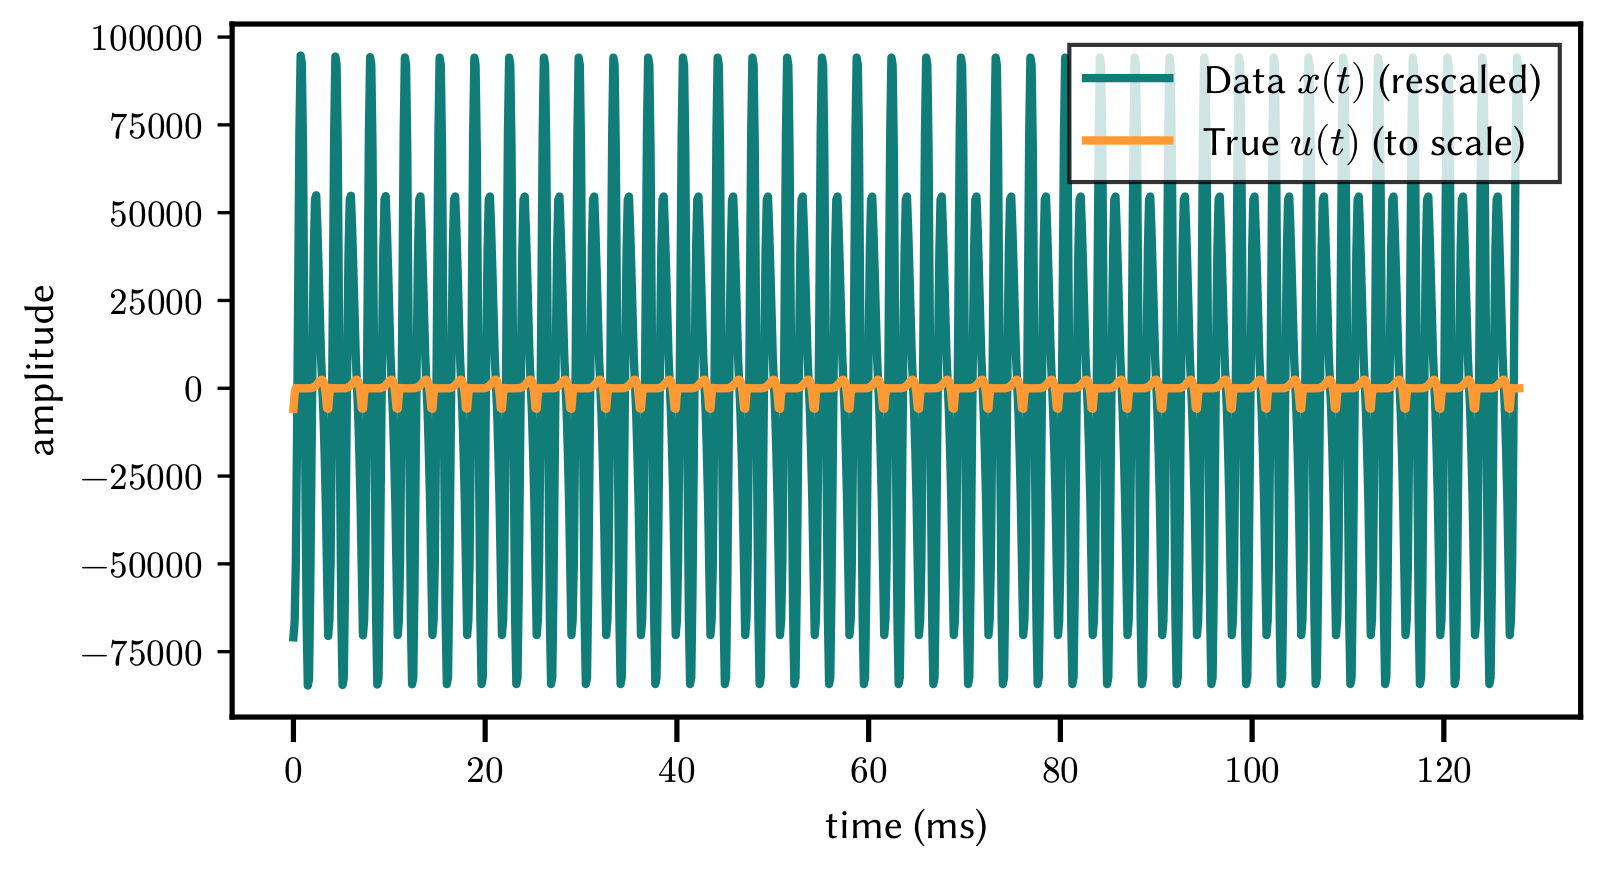

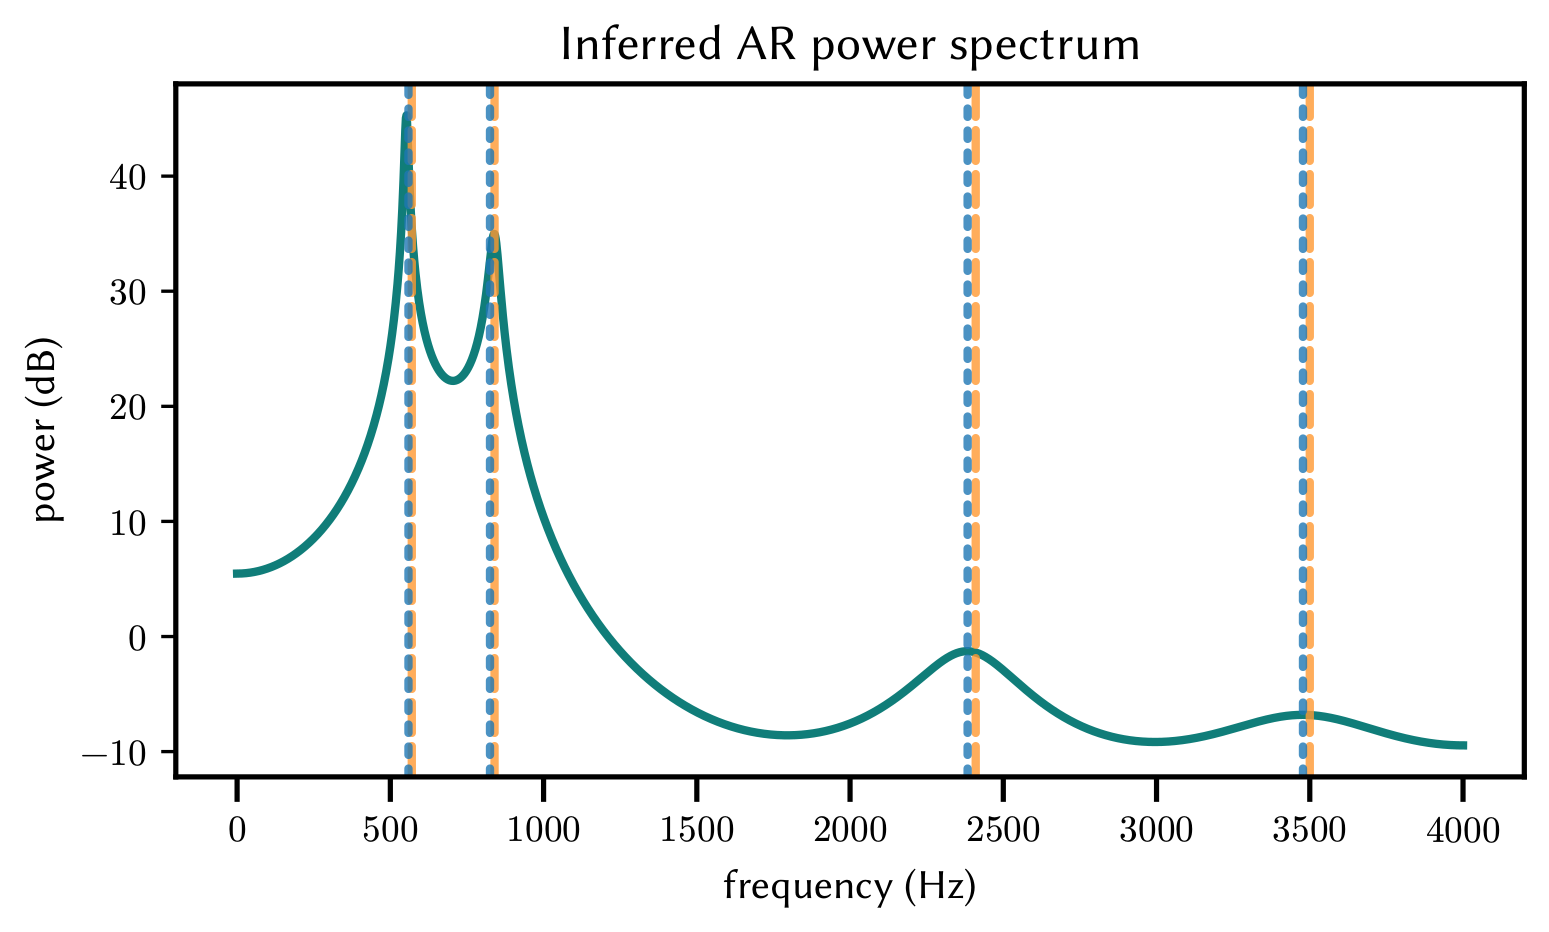

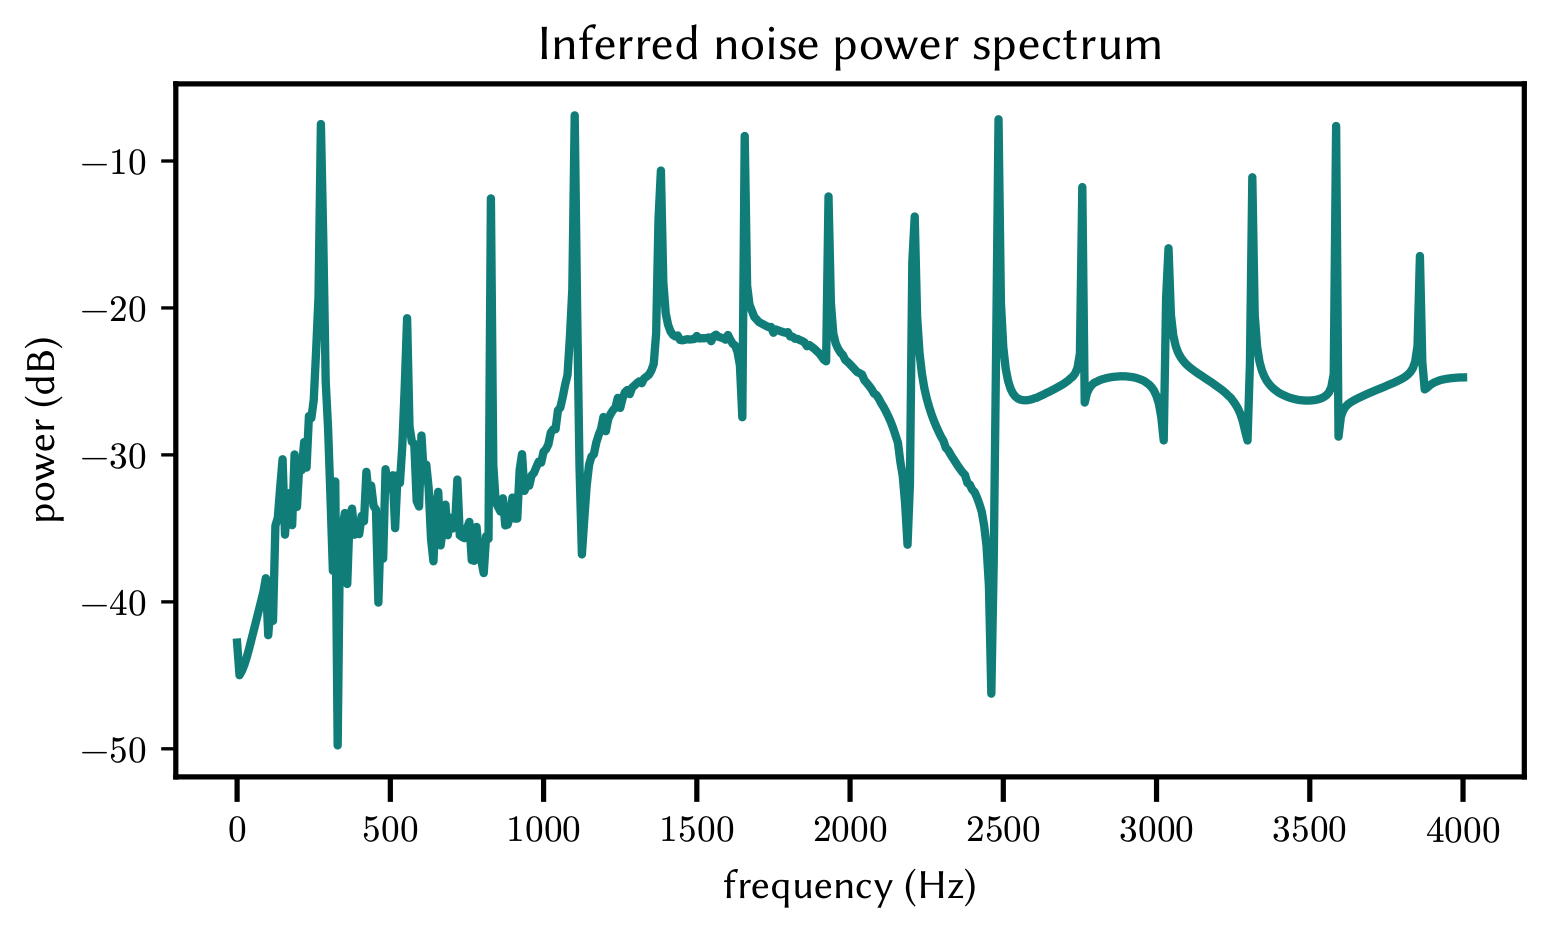

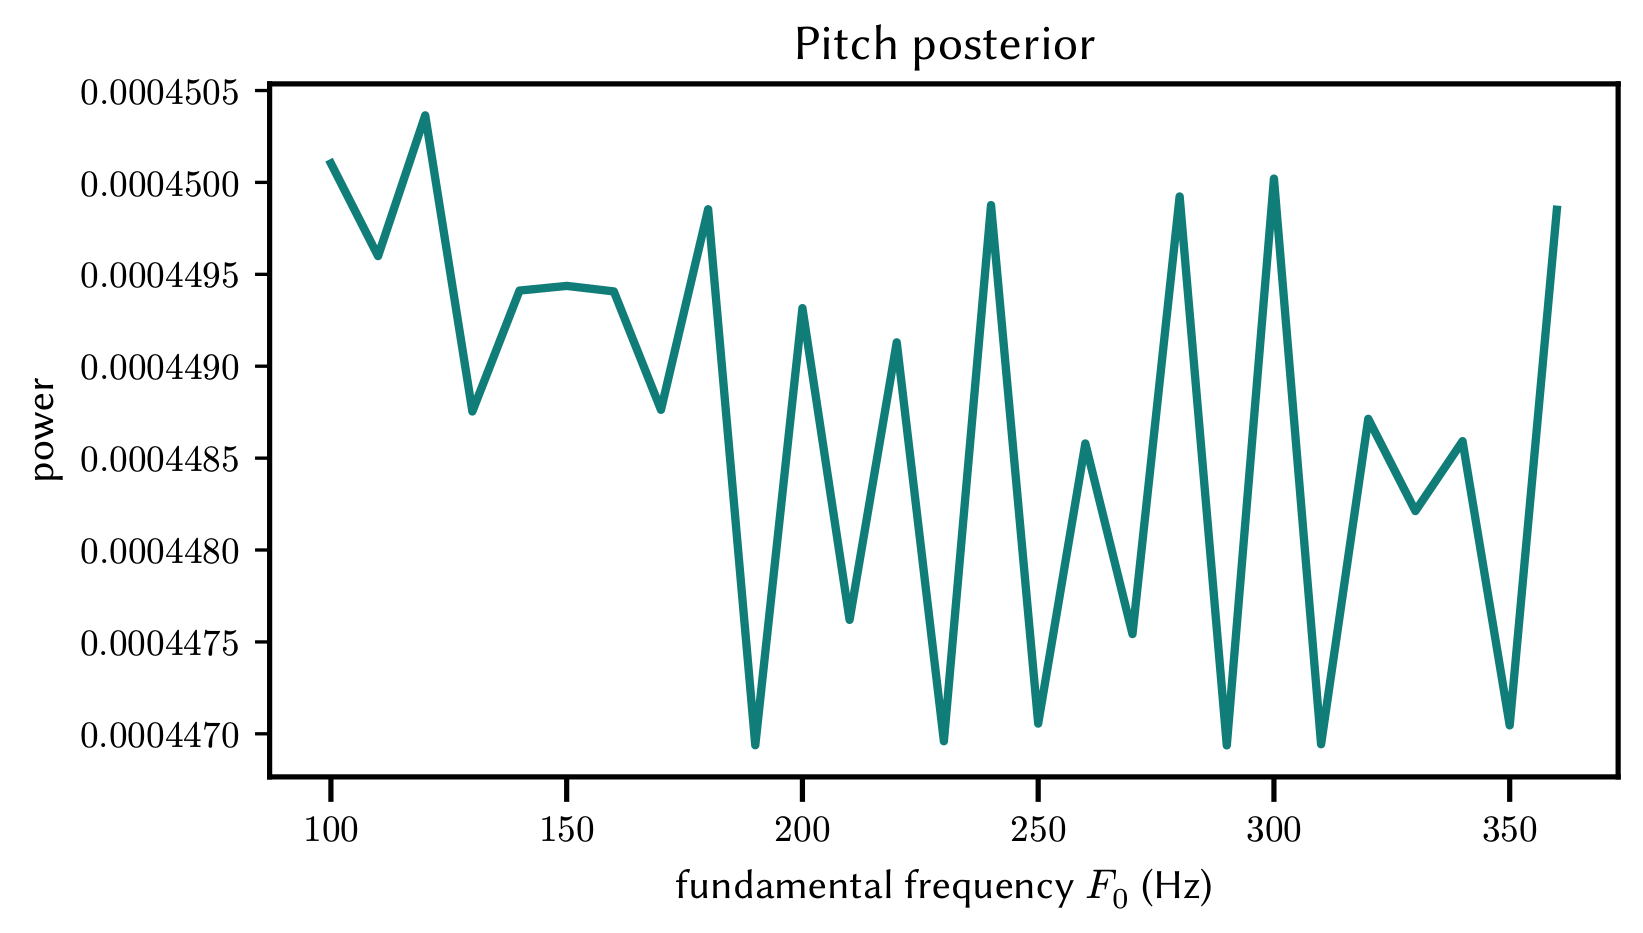

[<Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>,
 <Figure size 1740x900 with 1 Axes>]

In [15]:
# Plot best formant fit
i = int(np.nanargmin([r["formant_rmse"] for r in results]))
print(i)

OpenGlotI.plot_run(runs[i], metrics_list[i], f0, retain_plots=True)